In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
import pandas as pd
nlpfeatures = pd.read_csv('nlp_features_train.csv', encoding = 'latin-1')

In [3]:
nlpfeatures.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [4]:
feat = pd.read_csv("df_fe_without_preprocessing_train.csv")
feat.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [0]:
features_set1 = nlpfeatures.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
features_set2 = feat.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)


In [6]:
features_set1.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [7]:
features_set2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### Combining both the questions:

In [0]:
final = pd.DataFrame()
final['Text'] = feat['question1'] + ' ' + feat['question2']
final['id'] = feat['id']

In [9]:
final.head()

,Text,id
0,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,1
2,How can I increase the speed of my internet co...,2
3,Why am I mentally very lonely? How can I solve...,3
4,"Which one dissolve in water quikly sugar, salt...",4


In [0]:
temp = features_set1.merge(features_set2, on='id',how='left')
final  = temp.merge(final, on='id',how='left')

In [11]:
final.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,Text
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,What is the step by step guide to invest in sh...
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,How can I increase the speed of my internet co...
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,Why am I mentally very lonely? How can I solve...
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,"Which one dissolve in water quikly sugar, salt..."


In [0]:
final = final.drop('id',axis=1)

In [13]:
final.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,Text
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,What is the step by step guide to invest in sh...
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,How can I increase the speed of my internet co...
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,Why am I mentally very lonely? How can I solve...
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,"Which one dissolve in water quikly sugar, salt..."


### Checking NULL values:

In [14]:
nan_rows = final[final.isnull().any(1)]
print (nan_rows)

        cwc_min  cwc_max  csc_min  ...  freq_q1+q2  freq_q1-q2  Text
105780      0.0      0.0      0.0  ...           4           0   NaN
201841      0.0      0.0      0.0  ...           3           1   NaN
363362      0.0      0.0      0.0  ...           2           0   NaN

[3 rows x 27 columns]


In [15]:
final = final.fillna('')
nan_rows = final[final.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, Text]
Index: []


In [0]:
Y= nlpfeatures['is_duplicate']

### Splitting into Train and Test  (70-30):

In [0]:
X_train,X_test, Y_train, Y_test = train_test_split(final,Y, stratify=Y, test_size=0.3,random_state=13)

### Applying TFIDFVECTORIZER:

In [0]:
tfidf_vect = TfidfVectorizer()
train_tfidf = tfidf_vect.fit_transform(X_train['Text'])
test_tfidf = tfidf_vect.transform(X_test['Text'])


In [0]:
X_train_only_feat = X_train.drop('Text',axis=1)
X_test_only_feat = X_test.drop('Text',axis=1)

### Standardizing the features except text :

In [0]:
from sklearn.preprocessing import StandardScaler
S = StandardScaler(with_mean=False)
X_train_feat_st = S.fit_transform(X_train_only_feat)
X_test_feat_st = S.transform(X_test_only_feat)

In [0]:
X_train_question_hs = hstack((train_tfidf,X_train_feat_st))
X_test_question_hs = hstack((test_tfidf,X_test_feat_st))

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## LOGISTIC REGRESSION :

For values of alpha =  1e-05 The log loss is: 0.3733310812845078
For values of alpha =  0.0001 The log loss is: 0.39742427205229836
For values of alpha =  0.001 The log loss is: 0.4209601196842035
For values of alpha =  0.01 The log loss is: 0.447479022133859
For values of alpha =  0.1 The log loss is: 0.4858210720643679
For values of alpha =  1 The log loss is: 0.535685773065217
For values of alpha =  10 The log loss is: 0.6012434296049535


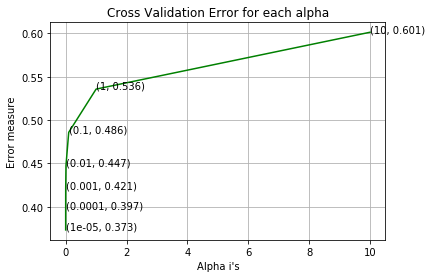

For values of best alpha =  1e-05 The train log loss is: 0.3626839031145786
For values of best alpha =  1e-05 The test log loss is: 0.3733310812845078
Total number of data points : 121287


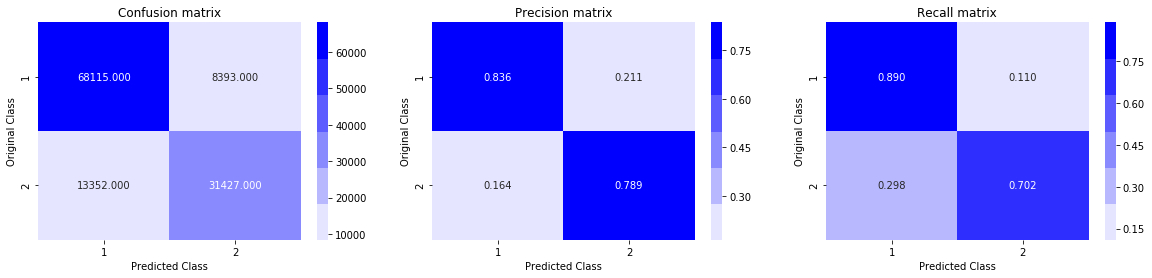

In [43]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_question_hs, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_question_hs, Y_train)
    predict_y = sig_clf.predict_proba(X_test_question_hs)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_question_hs, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_question_hs, Y_train)

predict_y = sig_clf.predict_proba(X_train_question_hs)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_question_hs)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## Linear Support Vector Machine :

For values of alpha =  1e-05 The log loss is: 0.395046444312474
For values of alpha =  0.0001 The log loss is: 0.4001929623140449
For values of alpha =  0.001 The log loss is: 0.43610619221619995
For values of alpha =  0.01 The log loss is: 0.45919314689131646
For values of alpha =  0.1 The log loss is: 0.5422523062032565
For values of alpha =  1 The log loss is: 0.6585278256322603
For values of alpha =  10 The log loss is: 0.6585278256322541


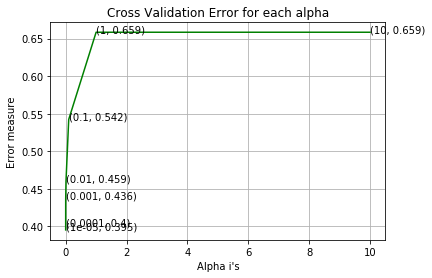

For values of best alpha =  1e-05 The train log loss is: 0.3875052978135108
For values of best alpha =  1e-05 The test log loss is: 0.395046444312474
Total number of data points : 121287


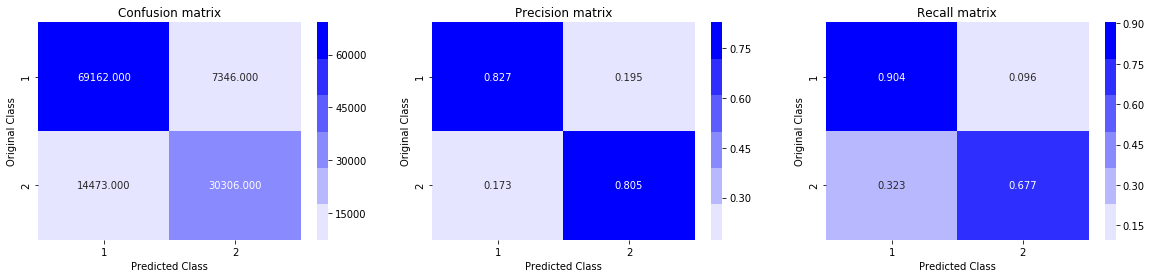

In [44]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_question_hs, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_question_hs, Y_train)
    predict_y = sig_clf.predict_proba(X_test_question_hs)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_question_hs, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_question_hs, Y_train)

predict_y = sig_clf.predict_proba(X_train_question_hs)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_question_hs)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## XGBOOST :

In [45]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

tuned_parameters={'n_estimators':[1,5,10,50,100],'max_depth':[1,4,5,7,8,10,50]}
model=RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1),tuned_parameters,scoring='neg_log_loss',cv=5)
model.fit(X_train_question_hs, Y_train)
print(model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


The test log loss is: 0.3162293802554583


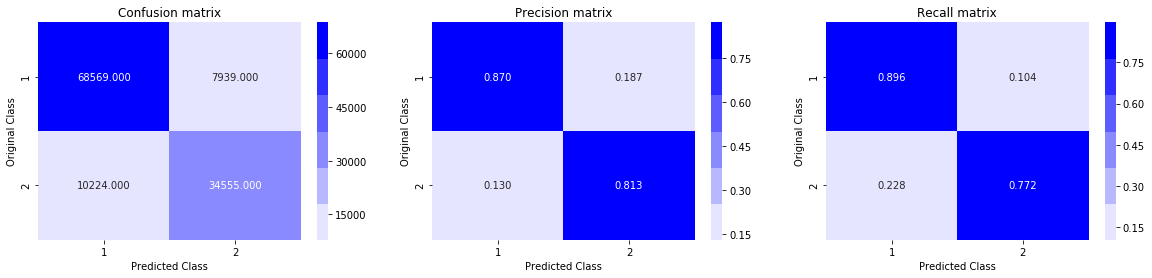

In [53]:
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=50,n_estimators=50,n_jobs=-1)
clf.fit(X_train_question_hs, Y_train)
predict_y = clf.predict_proba(X_test_question_hs)
print("The test log loss is:",log_loss(Y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(Y_test, predicted_y)

## TFIDF weighted W2V :

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train['Text']:
    list_of_sentance_train.append(sentance.split())

In [0]:

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_test=[]
for sentance in X_test['Text']:
    list_of_sentance_test.append(sentance.split())

In [26]:
from gensim.models import Word2Vec

want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


[('good', 0.7716791033744812), ('nice', 0.692537784576416), ('fun', 0.6902729868888855), ('good,', 0.6477619409561157), ('successful', 0.6461091041564941), ('cool', 0.6299347281455994), ('fun?', 0.6261299848556519), ('creative', 0.624901294708252), ('bad', 0.5963300466537476), ('funny', 0.594494640827179)]
[('funniest', 0.8225336670875549), ('craziest', 0.8097881078720093), ('biggest', 0.8034698367118835), ('weirdest', 0.7894008159637451), ('strangest', 0.7798976898193359), ('coolest', 0.7794346213340759), ('scariest', 0.7737215161323547), ('greatest', 0.7684834003448486), ('creepiest', 0.7566127777099609), ('hardest', 0.7556183934211731)]


In [27]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  42223
sample words  ['What', 'are', 'the', 'most', 'convenient', 'flights', 'between', 'Leeds', 'and', 'Ibiza,', 'how', 'do', 'tourist', 'attractions', 'compare', 'to', 'ones', 'in', 'Madrid?', 'Are', 'there', 'any', 'non-stop', 'what', 'main', 'attractions?', 'Why', 'I', 'want', 'join', 'Air', 'Force?', 'be', 'a', 'Fighter', 'Jet', 'pilot', 'US', 'military', 'branch', 'should', 'look', 'into?', 'How', 'can', 'improve', 'English', 'speaking', 'skill?', 'my']


In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train['Text'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [31]:
from tqdm import tqdm
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1  

100%|██████████| 283003/283003 [2:09:53<00:00, 36.31it/s]


In [32]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 121287/121287 [54:56<00:00, 34.98it/s]


In [0]:
X_train_question_hs1 =  np.hstack((tfidf_sent_vectors_train,X_train_feat_st))
X_test_question_hs1 =  np.hstack((tfidf_sent_vectors_test,X_test_feat_st))

In [36]:
import xgboost as xgb1
from sklearn.model_selection import RandomizedSearchCV

tuned_parameters={'n_estimators':[1,5,10,50,100],'max_depth':[1,4,5,7,8,10,50]}
model1=RandomizedSearchCV(xgb1.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1),tuned_parameters,scoring='neg_log_loss',cv=5)
model1.fit(X_train_question_hs1, Y_train)
print(model1.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


The test log loss is: 0.31572876601172273


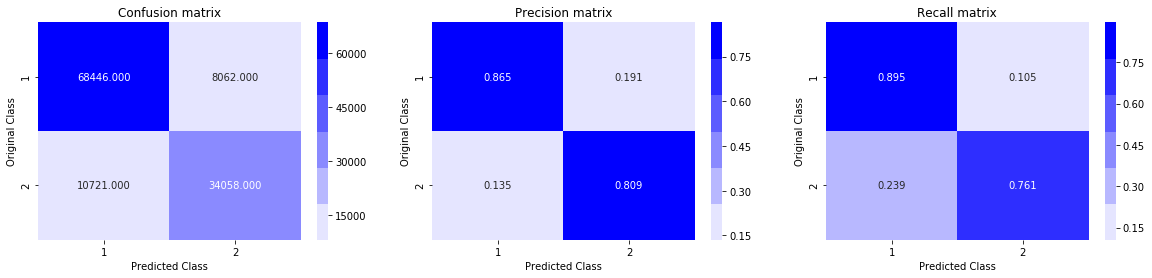

In [39]:
import xgboost as xgb
clf1 = xgb.XGBClassifier(max_depth=8,n_estimators=100,n_jobs=-1)
clf1.fit(X_train_question_hs1, Y_train)
predict_y = clf1.predict_proba(X_test_question_hs1)
print("The test log loss is:",log_loss(Y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(Y_test, predicted_y)

## OBSERVATIONS:

In [8]:
from prettytable import PrettyTable
    
x = PrettyTable(["METHOD", "Best Hyperparameter", "Test Logloss"])
x.align["METHOD"] = "l"
x.align["Best Hyperparameter"] = "l"
x.add_row(["Logistic Regression(Tfidf)"," alpha = 0.00001 \n ------------","0.3733\n -----------"])
x.add_row(["Linear SVM(Tfidf)"," alpha = 0.00001 \n ------------","0.3950\n -----------"])
x.add_row(["XGBOOST(Tfidf)","max depth =50\nn_estimators=50 \n ------------","0.3162\n ------------"])
x.add_row(["XGBOOST(Tfidf_weighted_w2v","max depth =8\nn_estimators=100 ","0.3157"])
print(x.get_string(title="UNIVARIATE ANALYSIS"))


+------------------------------------------------------------------+
|                       UNIVARIATE ANALYSIS                        |
+----------------------------+---------------------+---------------+
| METHOD                     | Best Hyperparameter |  Test Logloss |
+----------------------------+---------------------+---------------+
| Logistic Regression(Tfidf) |  alpha = 0.00001    |     0.3733    |
|                            |  ------------       |   ----------- |
| Linear SVM(Tfidf)          |  alpha = 0.00001    |     0.3950    |
|                            |  ------------       |   ----------- |
| XGBOOST(Tfidf)             | max depth =50       |     0.3162    |
|                            | n_estimators=50     |  ------------ |
|                            |  ------------       |               |
| XGBOOST(Tfidf_weighted_w2v | max depth =8        |     0.3157    |
|                            | n_estimators=100    |               |
+----------------------------+----

## Procedure :

1] Firstly we are combining all the features which we have engineered earlier.<br>
2] Before building a model we are combining both the question1 and question2 in to one dataframe and then adding all the features in to this dataframe.<br>
3] After building dataframe we are splitting into train and test (70-30).<br>
4] Then we are applying tfidfvectorizer on the text data which are combination of question1 and question2.<br>
5] Further we are hstacking both the tfidfvectorizered features with the features which we have engineered.<br>
6] We then build a Logistic regression, Linear SVM and XGBOOST model. XGBOOST implementation gave test logloss of 0.316.<br>
7] Then we are applying tfidf weighted W2V on the text data which are combination of question1 and question2 and by building an XGBOOST model on this text we get test Logloss of 0.3157.

In [2]:
import cv2